In [1]:
import os, sys, re
for path in sys.path:
    if re.match(".*/site-packages$", path):
        os.environ["GDAL_DATA"] = path + "/fiona/gdal_data"
        os.environ["PROJ_LIB"] = path + "/fiona/proj_data"

In [2]:
from pprint import pprint

# Geodaten lesen mit Fiona

In [3]:
import fiona

## Datensatz laden

Normalerweise präsentiert uns Fiona die Features des Layers in einer `collection`, welche direkt aus der Datei liest. Da wir hier im Jupyter Notebook zellen-basiert arbeiten und die Datei nicht die ganze Zeit offen lassen wollen. laden wir den gesamten Datensatz mit `list()` in den Arbeitsspeicher. 

Damit haben wir eine normale Python-Liste von Features, die Datei kann geschlossen werden.

*Dieser Trick klappt natürlich nur, wenn die Daten nicht zu umfangreich sind.*

Zusätzlich merken wir uns die Metainformation des Layers, nämlich das Koordinatenreferenzsystem (`crs`), das Format (`driver`) und das Schema (`schema`).

In [4]:
# TODO encoding...? bug report ist gemacht
with fiona.open("data/NUTS_RG_01M_2016_3035.shp", encoding="UTF-8") as source:
    nuts = list(source)  # -> in Arbeitsspeicher laden ;)
    nuts_meta = source.meta  # metadaten: schema, crs und driver
    nuts_bounds = source.bounds

In [5]:
nuts_meta.keys()

dict_keys(['driver', 'schema', 'crs', 'crs_wkt'])

Die Koordinaten beziehen sich auf EPSG:3035, also ETRS89 / LAEA Europe, ein System in Metern, perfekt für Europa:

In [6]:
pprint(nuts_meta['crs'])

{'ellps': 'GRS80',
 'lat_0': 52,
 'lon_0': 10,
 'no_defs': True,
 'proj': 'laea',
 'units': 'm',
 'x_0': 4321000,
 'y_0': 3210000}


In [7]:
pprint(nuts_meta['crs_wkt'])

'PROJCS["ETRS89_LAEA_Europe",GEOGCS["GCS_ETRS_1989",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["Meter",1]]'


Die eingelesene Datei war ein schnödes Shapefile:

In [8]:
pprint(nuts_meta['driver'])

'ESRI Shapefile'


Im Schema steht zum einen der Geometrietyp, zum anderen werden die Attribute (Spalten) beschrieben mit Namen und Datentyp:

In [9]:
pprint(nuts_meta['schema'])

{'geometry': 'Polygon',
 'properties': OrderedDict([('LEVL_CODE', 'int:1'),
                            ('NUTS_ID', 'str:5'),
                            ('CNTR_CODE', 'str:2'),
                            ('NUTS_NAME', 'str:106'),
                            ('FID', 'str:5')])}


Fiona gibt uns netterweise auch noch die minimalen und maximalen Werte des Datensatzes mit:

In [10]:
nuts_bounds

(-2824231.0, -3076163.0, 10026011.0, 5415879.0)

*Ja nu, ich will die Daten sehen!*

Ok, wir wählen mal ein bestimmtes Feature aus und greifen via seinem Listenindex darauf zu:

In [11]:
index = 123

In [12]:
nuts[index]

{'type': 'Feature',
 'id': '123',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[(5068154.0, 2612699.0),
     (5069619.0, 2611684.0),
     (5070175.0, 2610988.0),
     (5071125.0, 2610971.0),
     (5071717.0, 2610645.0),
     (5073347.0, 2608919.0),
     (5076348.0, 2608346.0),
     (5078106.0, 2607356.0),
     (5079939.0, 2609010.0),
     (5080057.0, 2609195.0),
     (5080573.0, 2610009.0),
     (5081487.0, 2610251.0),
     (5082083.0, 2610446.0),
     (5082415.0, 2610654.0),
     (5085199.0, 2612362.0),
     (5086605.0, 2613840.0),
     (5092460.0, 2614683.0),
     (5093221.0, 2614412.0),
     (5094426.0, 2611606.0),
     (5095089.0, 2611474.0),
     (5096216.0, 2611921.0),
     (5096767.0, 2611567.0),
     (5097031.0, 2612331.0),
     (5097499.0, 2613339.0),
     (5098077.0, 2614397.0),
     (5098736.0, 2615605.0),
     (5099488.0, 2615408.0),
     (5099547.0, 2614566.0),
     (5099824.0, 2614112.0),
     (5101910.0, 2612975.0),
     (5102472.0, 2612451.0),
     (5103311.

Wir sehen ein Dictionary mit vier Einträgen:

In [13]:
nuts[index].keys()

dict_keys(['type', 'id', 'geometry', 'properties'])

`type` sollte immer `"Feature"` sein. Die `id` korrespondiert meist mit der "`fid`". Beides ist uns heute ziemlich egal.

In [14]:
print(nuts[index]['type'])
print(nuts[index]['id'])

Feature
123


`properties` enthält - entsprechend des Schemas des Datensatzes - die tatsächlichen Attributwerte/Eigenschaften des Features. Als Datenstruktur finden wir (erneut) ein Dictionary:

In [15]:
type(nuts[index]['properties'])

collections.OrderedDict

Wir können über die Einträge darin iterieren:

In [16]:
for key, value in nuts[index]['properties'].items():
    print(f"{key:15}{value}")

LEVL_CODE      1
NUTS_ID        RS1
CNTR_CODE      RS
NUTS_NAME      Србија - север
FID            RS1


Oder direkt bestimmte Werte über ihren Key abfragen:

In [17]:
nuts[index]['properties']['NUTS_NAME']

'Србија - север'

In [18]:
nuts[index]['properties']['NUTS_ID']

'RS1'

In [19]:
for region in nuts:
    if region['properties']['CNTR_CODE'] == 'DE':
        print("{name} [{level}]".format(
            level=region['properties']['LEVL_CODE'],
            name=region['properties']['NUTS_NAME']
            )
        )

DEUTSCHLAND [0]
BADEN-WÜRTTEMBERG [1]
NORDRHEIN-WESTFALEN [1]
HESSEN [1]
BRANDENBURG [1]
RHEINLAND-PFALZ [1]
SCHLESWIG-HOLSTEIN [1]
SAARLAND [1]
SACHSEN-ANHALT [1]
SACHSEN [1]
THÜRINGEN [1]
BAYERN [1]
BERLIN [1]
MECKLENBURG-VORPOMMERN [1]
BREMEN [1]
HAMBURG [1]
NIEDERSACHSEN [1]
Freiburg [2]
Tübingen [2]
Oberbayern [2]
Stuttgart [2]
Niederbayern [2]
Karlsruhe [2]
Kassel [2]
Brandenburg [2]
Lüneburg [2]
Koblenz [2]
Weser-Ems [2]
Trier [2]
Mecklenburg-Vorpommern [2]
Münster [2]
Oberfranken [2]
Schwaben [2]
Darmstadt [2]
Braunschweig [2]
Detmold [2]
Mittelfranken [2]
Gießen [2]
Hannover [2]
Arnsberg [2]
Oberpfalz [2]
Unterfranken [2]
Düsseldorf [2]
Rheinhessen-Pfalz [2]
Dresden [2]
Berlin [2]
Bremen [2]
Hamburg [2]
Chemnitz [2]
Köln [2]
Saarland [2]
Sachsen-Anhalt [2]
Thüringen [2]
Leipzig [2]
Schleswig-Holstein [2]
Hamburg [3]
Darmstadt, Kreisfreie Stadt [3]
Frankfurt am Main, Kreisfreie Stadt [3]
Offenbach am Main, Kreisfreie Stadt [3]
Wiesbaden, Kreisfreie Stadt [3]
Bergstraße [3]
Werr

In [20]:
bundeslaender = []
for region in nuts:
    country = region['properties']['CNTR_CODE']
    level = region['properties']['LEVL_CODE']
    
    if country == 'DE' and level == 1:
        print(region['properties']['NUTS_NAME'])
        bundeslaender.append(region)

BADEN-WÜRTTEMBERG
NORDRHEIN-WESTFALEN
HESSEN
BRANDENBURG
RHEINLAND-PFALZ
SCHLESWIG-HOLSTEIN
SAARLAND
SACHSEN-ANHALT
SACHSEN
THÜRINGEN
BAYERN
BERLIN
MECKLENBURG-VORPOMMERN
BREMEN
HAMBURG
NIEDERSACHSEN


In [21]:
print(len(bundeslaender))

16


# Geometrie

Die `geometry` ist ebenfalls ein Dictionary, mit `type` und einer Liste von `coordinates`:

In [22]:
nuts[index]['geometry']

{'type': 'MultiPolygon',
 'coordinates': [[[(5068154.0, 2612699.0),
    (5069619.0, 2611684.0),
    (5070175.0, 2610988.0),
    (5071125.0, 2610971.0),
    (5071717.0, 2610645.0),
    (5073347.0, 2608919.0),
    (5076348.0, 2608346.0),
    (5078106.0, 2607356.0),
    (5079939.0, 2609010.0),
    (5080057.0, 2609195.0),
    (5080573.0, 2610009.0),
    (5081487.0, 2610251.0),
    (5082083.0, 2610446.0),
    (5082415.0, 2610654.0),
    (5085199.0, 2612362.0),
    (5086605.0, 2613840.0),
    (5092460.0, 2614683.0),
    (5093221.0, 2614412.0),
    (5094426.0, 2611606.0),
    (5095089.0, 2611474.0),
    (5096216.0, 2611921.0),
    (5096767.0, 2611567.0),
    (5097031.0, 2612331.0),
    (5097499.0, 2613339.0),
    (5098077.0, 2614397.0),
    (5098736.0, 2615605.0),
    (5099488.0, 2615408.0),
    (5099547.0, 2614566.0),
    (5099824.0, 2614112.0),
    (5101910.0, 2612975.0),
    (5102472.0, 2612451.0),
    (5103311.0, 2612713.0),
    (5105602.0, 2614536.0),
    (5107004.0, 2613662.0),
    (510

Damit können wir nicht viel anfangen... Glücklicherweise können wir dieses Geometrie-Dictionary ganz einfach in ein "echtes" Geometrieobjekt (im Sinne von Shapely) umwandeln.

In [23]:
from shapely.geometry import shape

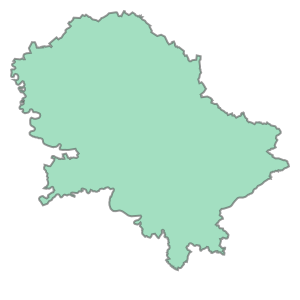

In [24]:
shape(nuts[index]['geometry'])

Im Jupyter Notebook werden Shapely-Geometrien grafisch dargestellt!

Aber vor allem können wir jetzt mit geometrischen Funktionen und Methoden arbeiten.

## Mini-Exkurs: Geometrien mit Shapely

In [25]:
from shapely.geometry import *

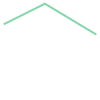

In [26]:
LineString(
    (
        Point(1,2),
        Point(5,4),
        Point(10,1)
    )
)

Wer mehr zu Shapely wissen will, guckt sich z.B. mein Notebook vom letzten Jahr an.

Heute müsst ihr einige Dinge einfach hinnehmen und erstmal nicht verstehen.

# Zurück zu den NUTS

In [27]:
nuts_bounds

(-2824231.0, -3076163.0, 10026011.0, 5415879.0)

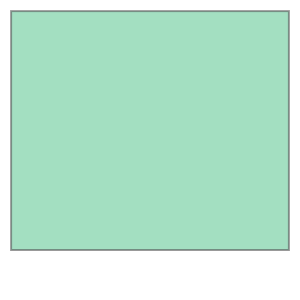

In [28]:
europe_extents = box(2.5e6, 1.2e6, 7.5e6, 5.5e6)
europe_extents

Um mit den Geometrien zu arbeiten, legen wir uns eine zweite Liste an. Während in `nuts` die Features drin stecken, kommen in `nuts_geometries` die ("shapelifizierten") Geometrien.

In [29]:
nuts_geometries = [shape(f['geometry']) for f in nuts]

Da Listen eine feste Reihenfolge haben und wir die zweite Liste anhand der erste erstellen, sind ihre Anordnungen zueinander passend. Z.B. finden wir an Index 42 das Feature bzw. die Geometrie von Surinam:

In [30]:
index = 42

In [31]:
nuts[index]

{'type': 'Feature',
 'id': '42',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[(4464133.0, 3311150.0),
     (4463872.0, 3310652.0),
     (4463803.0, 3309857.0),
     (4464462.0, 3308452.0),
     (4464406.0, 3307358.0),
     (4467079.0, 3308364.0),
     (4468663.0, 3309671.0),
     (4469798.0, 3308462.0),
     (4470367.0, 3308458.0),
     (4470478.0, 3308243.0),
     (4470902.0, 3308210.0),
     (4471240.0, 3307909.0),
     (4472244.0, 3303855.0),
     (4472990.0, 3302208.0),
     (4472708.0, 3300460.0),
     (4472277.0, 3299971.0),
     (4471404.0, 3300187.0),
     (4470874.0, 3300100.0),
     (4470956.0, 3298702.0),
     (4470409.0, 3298250.0),
     (4470306.0, 3297431.0),
     (4469973.0, 3296824.0),
     (4470186.0, 3296158.0),
     (4470812.0, 3295728.0),
     (4471021.0, 3294593.0),
     (4469691.0, 3293369.0),
     (4469928.0, 3293146.0),
     (4469844.0, 3292901.0),
     (4469526.0, 3292190.0),
     (4470219.0, 3292147.0),
     (4470280.0, 3291928.0),
     (4470027.0

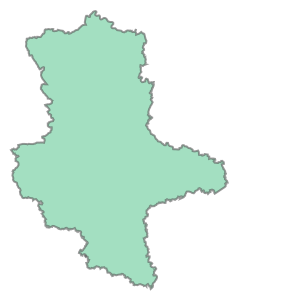

In [32]:
nuts_geometries[index]

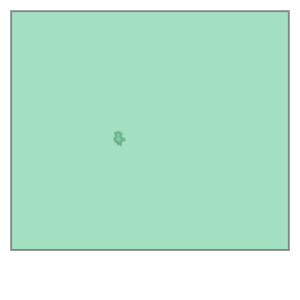

In [33]:
GeometryCollection((
    nuts_geometries[index],
    europe_extents
))

# Eigenschaften und Beziehungen

In [34]:
nuts_geometries[index].area / (1000*1000)  #qkm²

20553.44076

In [35]:
hamburg = Point(4320554.5,3382494.8)

In [36]:
hamburg.within(nuts_geometries[index])

False

In [37]:
for feature, geometry in zip(nuts, nuts_geometries):
    if hamburg.within(geometry):
        print(feature['properties'])

OrderedDict([('LEVL_CODE', 0), ('NUTS_ID', 'DE'), ('CNTR_CODE', 'DE'), ('NUTS_NAME', 'DEUTSCHLAND'), ('FID', 'DE')])
OrderedDict([('LEVL_CODE', 1), ('NUTS_ID', 'DE6'), ('CNTR_CODE', 'DE'), ('NUTS_NAME', 'HAMBURG'), ('FID', 'DE6')])
OrderedDict([('LEVL_CODE', 2), ('NUTS_ID', 'DE60'), ('CNTR_CODE', 'DE'), ('NUTS_NAME', 'Hamburg'), ('FID', 'DE60')])
OrderedDict([('LEVL_CODE', 3), ('NUTS_ID', 'DE600'), ('CNTR_CODE', 'DE'), ('NUTS_NAME', 'Hamburg'), ('FID', 'DE600')])


## Geodaten schreiben

Da Polygone und MultiPolygone gemischt sind, können wir leider kein GeoPackage schreiben. Aber ein Shapefile frisst alles...

In [38]:
with fiona.open("nuts_2.shp", "w",
               schema=nuts_meta['schema'], crs=nuts_meta['crs'],
               driver="ESRI Shapefile") as sink:
    
    for feature in nuts:
        if feature['properties']['LEVL_CODE'] == 2:
            sink.write(feature)

## Welche Airports sind in den Bundesländern?

In [39]:
# Daten von anderem Notebook laden
%store -r airports
%store -r airports_geometries_3035

In [40]:
for bundesland in bundeslaender:
    bundesland_geometry = shape(bundesland['geometry'])
    print(f"##### In {bundesland['properties']['NUTS_NAME']} liegt:")
    
    for airport, airport_geometry in zip(airports, airports_geometries_3035):
        #print(airport)
        if airport_geometry.intersects(bundesland_geometry):
            print(airport['properties']['Name'])
            airport['properties']['NUTS_NAME'] = bundesland['properties']['NUTS_NAME']

##### In BADEN-WÜRTTEMBERG liegt:
Stuttgart Airport
Mannheim-City Airport
Biberach a.d. Riß Airport
Leutkirch-Unterzeil Airport
Friedrichshafen Airport
Aalen-Heidenheim/Elchingen Airport
Donaueschingen-Villingen Airport
Freiburg i. Br. Airport
Mengen-Hohentengen Airport
Adolf Würth Airport
Laupheim Air Base
Niederstetten Army Air Base
Coleman Army Air Field
Karlsruhe Baden-Baden Airport
Tannheim Airport
Nabern/Teck Airport
Linkenheim Airport
Lahr Airport
Karlsruhe-Forchheim Airport
Weinheim/Bergstraße Airport
Bremgarten Airport
##### In NORDRHEIN-WESTFALEN liegt:
Münster Osnabrück Airport
Cologne Bonn Airport
Düsseldorf Airport
Siegerland Airport
Flugplatz Dahlemer Binz
Meinerzhagen Airport
Arnsberg-Menden Airport
Essen Mulheim Airport
Bielefeld Airport
Mönchengladbach Airport
Paderborn Lippstadt Airport
Stadtlohn-Vreden Airport
Dortmund Airport
Rheine Bentlage Air Base
Geilenkirchen Air Base
Nörvenich Air Base
Gütersloh Air Base
Aachen-Merzbrück Airport
Weeze Airport
Dinslaken/Schwarz